# 영화 관객수 예측 분석
- 전에 r2-score 지표가 성능이 좋지 않아 데이터의 결측값을 모두 대채하여 사용

## 데이터 로딩

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv('data/movies_train.csv')
test  = pd.read_csv('data/movies_test.csv')

print(train.shape, test.shape)

(600, 12) (243, 11)


## 데이터
- title : 영화의 제목
- distributor : 배급사
- genre : 장르
- release_time : 개봉일
- time : 상영시간(분)
- screening_rat : 상영등급
- director : 감독이름
- dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
- dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
- num_staff : 스텝수
- num_actor : 주연배우수
- box_off_num : 관객수

## 데이터 확인

In [2]:
# 결측값 확인
print(train.isna().sum())

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64


In [3]:
print(test.isna().sum())

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64


In [4]:
train[train['dir_prev_bfnum'].isna()].head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
6,길위에서,백두대간,다큐멘터리,2013-05-23,104,전체 관람가,이창재,NaN,0,32,5,53526
8,"1789, 바스티유의 연인들",유니버설픽쳐스인터내셔널코리아,뮤지컬,2014-09-18,129,전체 관람가,정성복,NaN,0,3,5,4778
9,청춘그루브,(주)두타연,드라마,2012-03-15,94,15세 관람가,변성현,NaN,0,138,3,868
10,AV 아이돌,(주) 케이알씨지,멜로/로맨스,2015-07-27,89,청소년 관람불가,조조 히데오,NaN,0,0,4,745


In [5]:
train['dir_prev_bfnum'].describe()

count    2.700000e+02
mean     1.050443e+06
std      1.791408e+06
min      1.000000e+00
25%      2.038000e+04
50%      4.784236e+05
75%      1.286569e+06
max      1.761531e+07
Name: dir_prev_bfnum, dtype: float64

In [6]:
# 'dir_prev_bfnum'이 NaN이며 'dir_prev_num'이 0
train[train['dir_prev_bfnum'].isna()]['dir_prev_num'].sum()

0

In [7]:
# 'dir_prev_num'이 0이라면 'dir_prev_bfnum'도 0이라고 판단
# 따라서 'dir_prev_num'의 결측값을 0으로 변환
train['dir_prev_bfnum'].fillna(0, inplace=True)
test['dir_prev_bfnum'].fillna(0, inplace = True)

print(train.isna().sum())
print(test.isna().sum())

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
box_off_num       0
dtype: int64
title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
dtype: int64


## 명목형 변수 확인

In [8]:
print(train.title.unique().shape) # 제목
print(train.distributor.unique().shape) # 배급사
print(train.genre.unique().shape) # 장르
print(train.release_time.unique().shape) # 개봉일
print(train.screening_rat.unique().shape) # 상영등급
print(train.director.unique().shape) # 감독

# 제목, 배급사, 감독은 학습할 때 제외
# 개봉일은 계절로 바꿔 봄, 여름, 가을, 겨울로 변환
# 장르, 계절, 상영등급 원핫 인코딩

(600,)
(169,)
(12,)
(330,)
(4,)
(472,)


In [9]:
# 개봉일 계절로 변환
## 개봉일의 월 추출
train['month'] = pd.to_datetime(train['release_time']).dt.month
test['month'] = pd.to_datetime(test['release_time']).dt.month

train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,month
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.00,0,91,2,23398,11
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,11
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083,6
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866,7
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387,11


In [10]:
# 함수를 이용해 계절 컬럼 추가

def season(month):
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:
        return '겨울'
    
train['season'] = train['month'].apply(lambda x : season(x))
test['season'] = test['month'].apply(lambda x : season(x))

train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,month,season
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.00,0,91,2,23398,11,가을
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,11,가을
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083,6,여름
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866,7,여름
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387,11,가을


## 변수 구분

In [11]:
DEL_COL = ['title', 'release_time', 'month', 'distributor', 'director']
COL_CAT = ['genre', 'screening_rat', 'season']
COL_NUM = ['dir_prev_bfnum', 'dir_prev_num', 'time', 'num_staff', 'num_actor']
COL_Y = ['box_off_num']

X_train = train[COL_CAT + COL_NUM]
X_test = test[COL_CAT + COL_NUM]
y_train = train[COL_Y]

## 범주형 변수 OneHotEncoding

In [12]:
from sklearn.preprocessing import OneHotEncoder

X = pd.concat([X_train, X_test])

ohe = OneHotEncoder(handle_unknown= 'ignore')
ohe.fit(X[COL_CAT])
X_train_res = ohe.transform(X_train[COL_CAT])
X_test_res = ohe.transform(X_test[COL_CAT])

In [13]:
X_train_ohe = pd.DataFrame(X_train_res.todense(), columns = ohe.get_feature_names_out())
X_test_ohe = pd.DataFrame(X_test_res.todense(), columns = ohe.get_feature_names_out())

X_train = pd.concat([X_train[COL_NUM], X_train_ohe], axis = 1)
X_test = pd.concat([X_test[COL_NUM], X_test_ohe], axis = 1)

X_train.head()

,dir_prev_bfnum,dir_prev_num,time,num_staff,num_actor,genre_SF,genre_공포,genre_느와르,genre_다큐멘터리,genre_드라마,...,genre_액션,genre_코미디,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가,season_가을,season_겨울,season_봄,season_여름
0,0.00,0,96,91,2,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,1161602.50,2,130,387,3,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,220775.25,4,123,343,4,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,23894.00,2,101,20,6,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.00,1,108,251,2,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


## 연속형 변수 확인

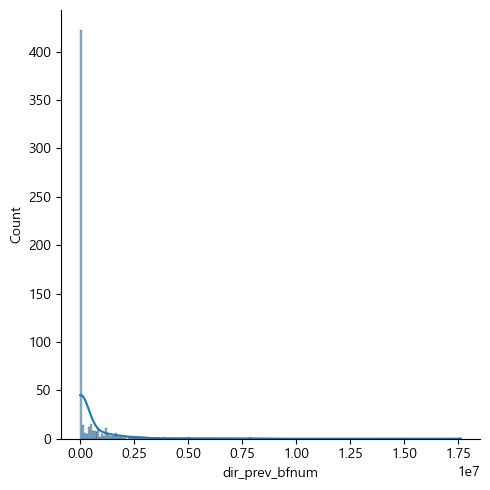

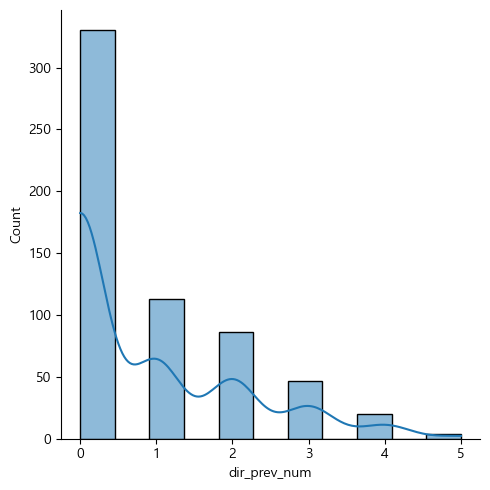

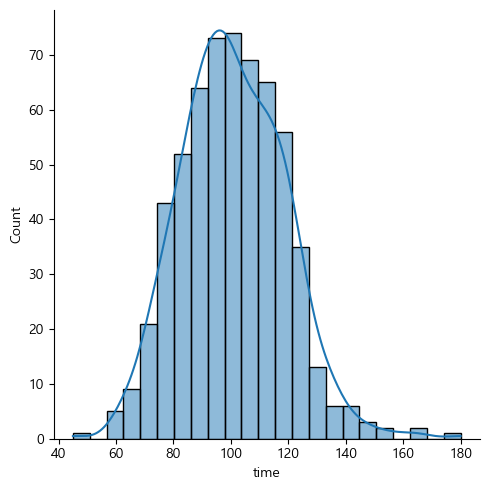

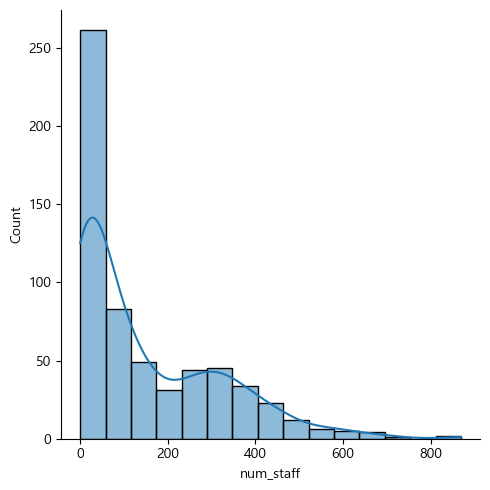

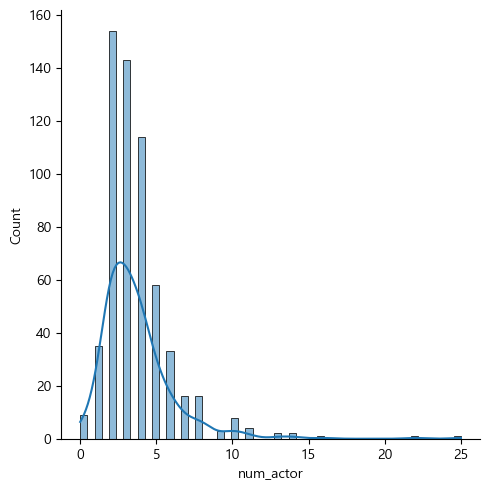

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

for i in COL_NUM:
    sns.displot(X_train[i], kde = True)
    plt.show()

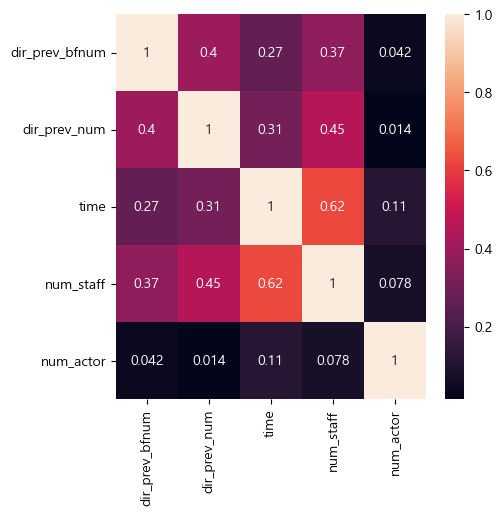

In [15]:
plt.figure(figsize = (5, 5))
sns.heatmap(X_train[COL_NUM].corr(), annot = True)
plt.show()

## 정규성 검정

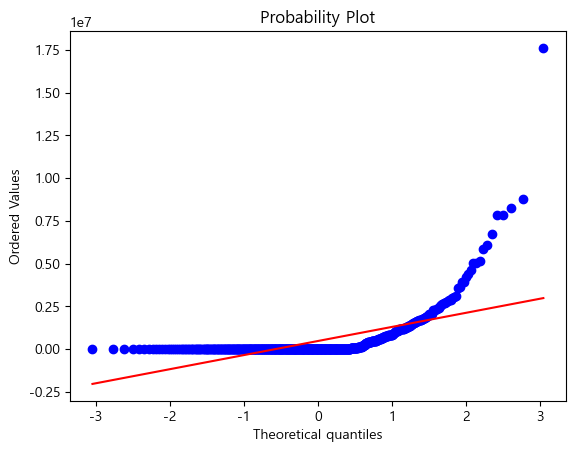

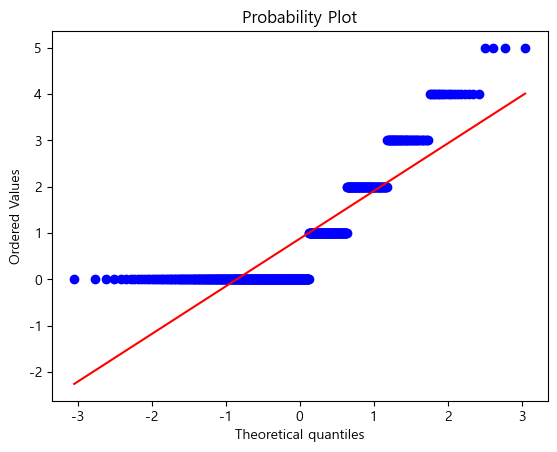

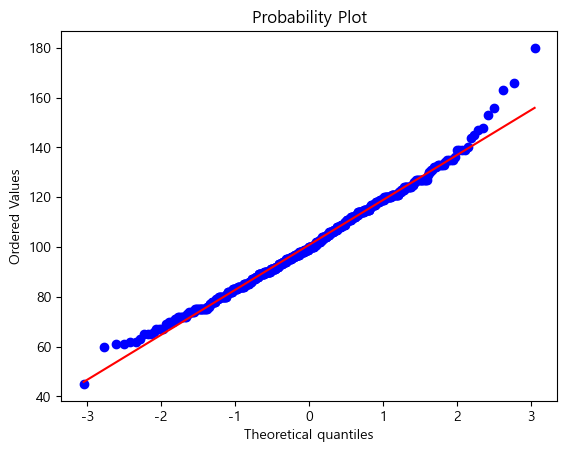

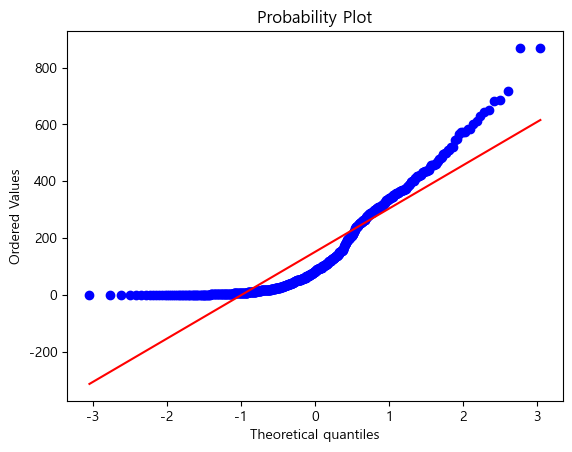

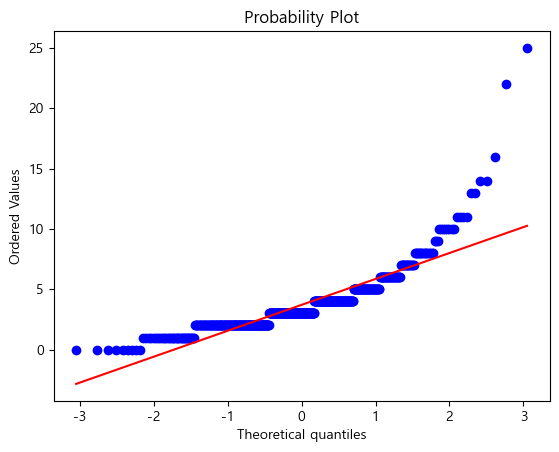

In [16]:
from scipy import stats

for i in COL_NUM:
    stats.probplot(X_train[i], plot = plt)
    plt.show()

## 이상치 확인

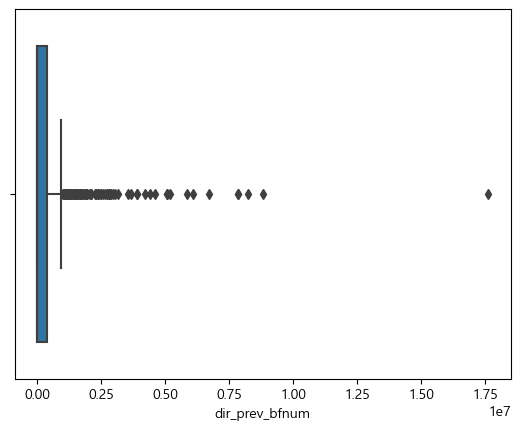

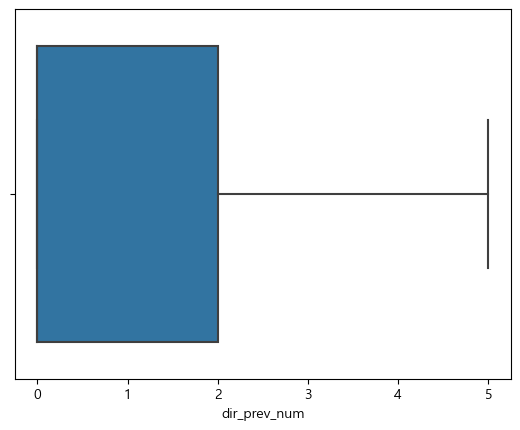

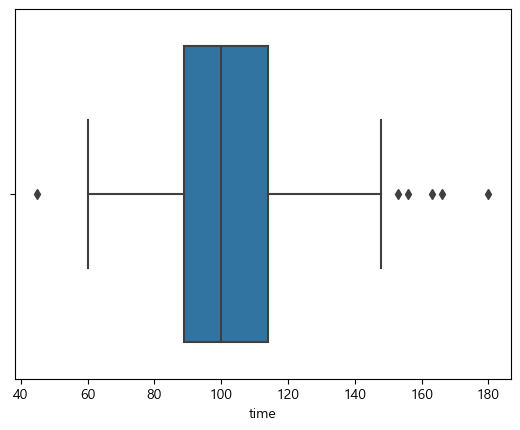

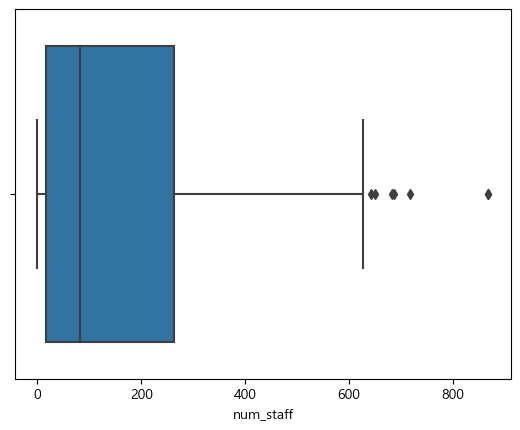

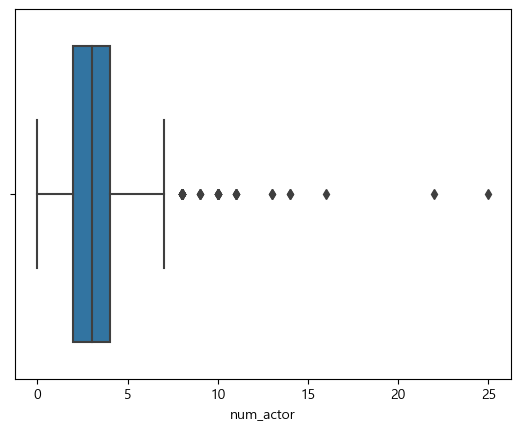

In [17]:
for i in COL_NUM:
    sns.boxplot(x = X_train[i], data = X_train)
    plt.show()

## 이상치 대체

In [19]:
for i in COL_NUM:
    Q1 = X_train[i].quantile(0.25)
    Q3 = X_train[i].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    X_train[i] = np.where(X_train[i] < lower, lower, X_train[i])
    X_train[i] = np.where(X_train[i] > upper, upper, X_train[i])

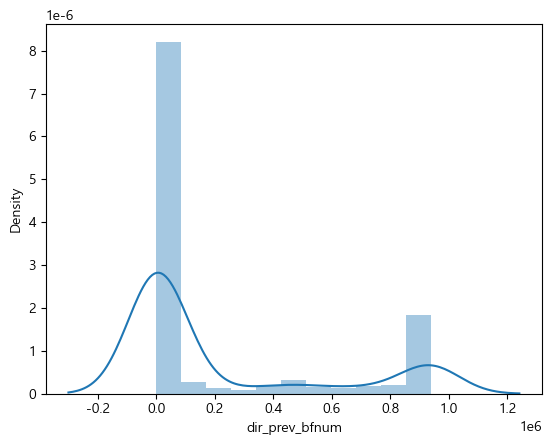

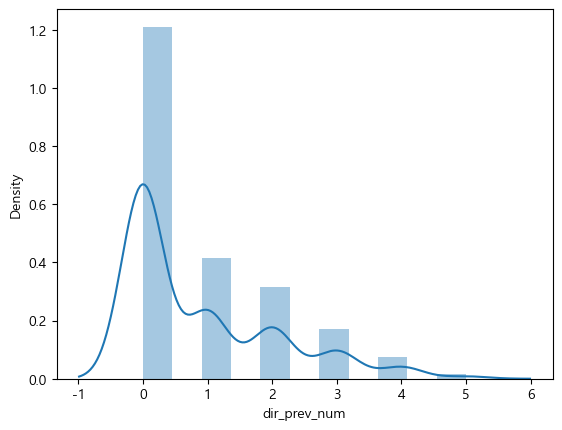

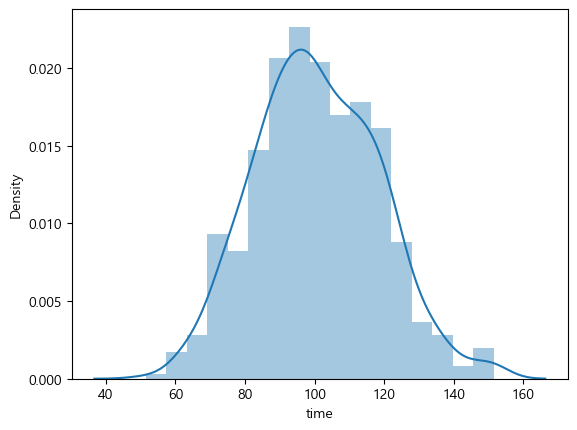

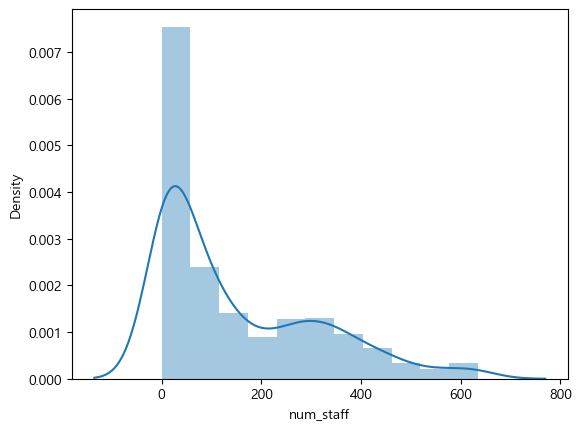

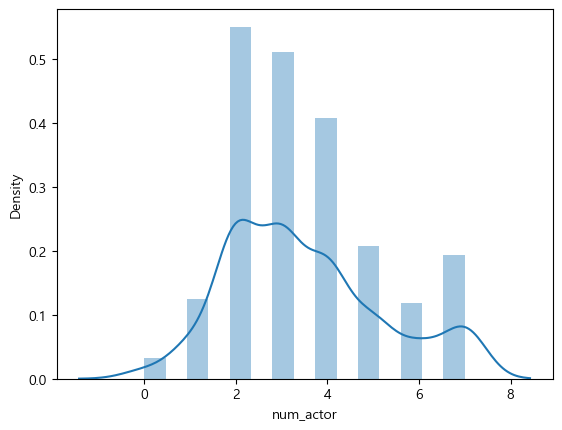

In [20]:
import warnings
warnings.filterwarnings('ignore')

for i in COL_NUM:
    sns.distplot(X_train[i], kde = True, hist = True)
    plt.show()

## 왜도 검사

In [21]:
from scipy.stats import skew, kurtosis
skew_d = {}
for i in COL_NUM:
    skew_d[i] = skew(X_train[i])
    
print(skew_d)

{'dir_prev_bfnum': 1.2858791824834501, 'dir_prev_num': 1.2496276916957825, 'time': 0.19681028573282544, 'num_staff': 1.0761209115564683, 'num_actor': 0.5485867491750385}


## 데이터 분할

In [22]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train.values.ravel(), test_size = 0.2)

X_tr.head()

,dir_prev_bfnum,dir_prev_num,time,num_staff,num_actor,genre_SF,genre_공포,genre_느와르,genre_다큐멘터리,genre_드라마,...,genre_액션,genre_코미디,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가,season_가을,season_겨울,season_봄,season_여름
565,0.0,0.0,75.0,80.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
430,3534.0,1.0,80.0,26.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
566,385977.5,2.0,112.0,245.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0.0,0.0,104.0,32.0,5.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
572,0.0,0.0,97.0,51.0,3.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [23]:
X_tr[COL_NUM].describe()

,dir_prev_bfnum,dir_prev_num,time,num_staff,num_actor
count,480.000000,480.000000,480.00000,480.000000,480.000000
mean,218305.728038,0.881250,100.52500,146.778125,3.462500
std,360769.992450,1.188173,17.74878,158.283737,1.737061
min,0.000000,0.000000,51.50000,0.000000,0.000000
25%,0.000000,0.000000,89.00000,17.000000,2.000000
50%,0.000000,0.000000,99.00000,80.500000,3.000000
75%,402181.583333,2.000000,114.00000,262.250000,4.000000
max,940354.062500,5.000000,151.50000,634.500000,7.000000


## 데이터 스케일링

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_tr[COL_NUM] = scaler.fit_transform(X_tr[COL_NUM])
X_val[COL_NUM] = scaler.transform(X_val[COL_NUM])
X_test[COL_NUM] = scaler.transform(X_test[COL_NUM])

X_tr[COL_NUM].head()

,dir_prev_bfnum,dir_prev_num,time,num_staff,num_actor
565,0.000000,0.0,0.235,0.126084,0.428571
430,0.003758,0.2,0.285,0.040977,0.285714
566,0.410460,0.4,0.605,0.386131,1.000000
6,0.000000,0.0,0.525,0.050433,0.714286
572,0.000000,0.0,0.455,0.080378,0.428571


## RandomForestRegressor

In [25]:
from sklearn.ensemble import RandomForestRegressor

modelRF = RandomForestRegressor()
modelRF.fit(X_tr, y_tr)

y_tr_pred = modelRF.predict(X_tr)
y_val_pred = modelRF.predict(X_val)

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse_tr = mean_squared_error(y_tr, y_tr_pred)
rmse_tr = mean_squared_error(y_tr, y_tr_pred, squared = False)
mae_tr = mean_absolute_error(y_tr, y_tr_pred)
r2_tr = r2_score(y_tr, y_tr_pred)

mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = mean_squared_error(y_val, y_val_pred, squared = False)
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

print('MSE')
print('MSE(tr) : ', mse_tr)
print('MSE(val) : ', mse_val)
print('='*40)
print('RMSE')
print('RMSE(tr) : ', rmse_tr)
print('RMSE(val) : ', rmse_val)
print('='*40)
print('MAE')
print('MAE(tr) : ', mae_tr)
print('MAE(val) : ', mae_val)
print('='*40)
print('r2_score')
print('r2_score(tr) : ', r2_tr)
print('r2_score(val) : ', r2_val)
print('='*40)


MSE
MSE(tr) :  328116164435.7426
MSE(val) :  2356973547556.404
RMSE
RMSE(tr) :  572814.249504796
RMSE(val) :  1535243.8072034044
MAE
MAE(tr) :  252763.5861666667
MAE(val) :  702466.2795000001
r2_score
r2_score(tr) :  0.9047983673424123
r2_score(val) :  0.18553311788539661


In [27]:
importance = pd.DataFrame({'feature' : X_tr.columns, 'feature_importance' : modelRF.feature_importances_})
importance = importance.sort_values('feature_importance')

importance

,feature,feature_importance
13,genre_서스펜스,5.405115e-08
12,genre_미스터리,4.170695e-05
11,genre_뮤지컬,7.347221e-05
8,genre_다큐멘터리,3.860568e-04
14,genre_애니메이션,3.953822e-04
19,screening_rat_전체 관람가,6.007454e-04
10,genre_멜로/로맨스,8.550594e-04
6,genre_공포,2.504345e-03
17,screening_rat_12세 관람가,6.859204e-03
23,season_봄,9.547877e-03


### 하이퍼파라미터 튜닝

In [50]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators' : range(100, 601, 50),
    'max_depth' : range(1, 11), 
    'criterion' : ['squared_error', 'absolute_error'], 
    'max_features' : ['sqrt', 'log2', None]
}

gs = GridSearchCV(RandomForestRegressor(),
                        params,
                        scoring = ['neg_mean_squared_error', 'r2'],
                        cv = 5,
                        n_jobs = -1,
                        refit = 'neg_mean_squared_error'
                        )
gs.fit(X_tr, y_tr)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': range(1, 11),
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': range(100, 601, 50)},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'r2'])

In [51]:
gs.best_params_

{'criterion': 'squared_error',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [52]:
from sklearn.ensemble import RandomForestRegressor

modelRF = RandomForestRegressor(n_estimators = 100, max_depth = 8, criterion = 'squared_error', max_features = 'sqrt')
modelRF.fit(X_tr, y_tr)

y_tr_pred = modelRF.predict(X_tr)
y_val_pred = modelRF.predict(X_val)

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse_tr = mean_squared_error(y_tr, y_tr_pred)
rmse_tr = mean_squared_error(y_tr, y_tr_pred, squared = False)
mae_tr = mean_absolute_error(y_tr, y_tr_pred)
r2_tr = r2_score(y_tr, y_tr_pred)

mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = mean_squared_error(y_val, y_val_pred, squared = False)
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

print('MSE')
print('MSE(tr) : ', mse_tr)
print('MSE(val) : ', mse_val)
print('='*40)
print('RMSE')
print('RMSE(tr) : ', rmse_tr)
print('RMSE(val) : ', rmse_val)
print('='*40)
print('MAE')
print('MAE(tr) : ', mae_tr)
print('MAE(val) : ', mae_val)
print('='*40)
print('r2_score')
print('r2_score(tr) : ', r2_tr)
print('r2_score(val) : ', r2_val)
print('='*40)

MSE
MSE(tr) :  479461811238.0944
MSE(val) :  1669241262578.6526
RMSE
RMSE(tr) :  692431.8098109694
RMSE(val) :  1291991.2006583684
MAE
MAE(tr) :  336175.5517855045
MAE(val) :  620128.0376007636
r2_score
r2_score(tr) :  0.8608860148498723
r2_score(val) :  0.4231832902668822


## XGBRegressor

In [54]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_tr, y_tr)

y_tr_pred_xgb = model_xgb.predict(X_tr)
y_val_pred_xgb = model_xgb.predict(X_val)

In [55]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse_tr = mean_squared_error(y_tr, y_tr_pred_xgb)
rmse_tr = mean_squared_error(y_tr, y_tr_pred_xgb, squared = False)
mae_tr = mean_absolute_error(y_tr, y_tr_pred_xgb)
r2_tr = r2_score(y_tr, y_tr_pred_xgb)

mse_val = mean_squared_error(y_val, y_val_pred_xgb)
rmse_val = mean_squared_error(y_val, y_val_pred_xgb, squared = False)
mae_val = mean_absolute_error(y_val, y_val_pred_xgb)
r2_val = r2_score(y_val, y_val_pred_xgb)

print('MSE')
print('MSE(tr) : ', mse_tr)
print('MSE(val) : ', mse_val)
print('='*40)
print('RMSE')
print('RMSE(tr) : ', rmse_tr)
print('RMSE(val) : ', rmse_val)
print('='*40)
print('MAE')
print('MAE(tr) : ', mae_tr)
print('MAE(val) : ', mae_val)
print('='*40)
print('r2_score')
print('r2_score(tr) : ', r2_tr)
print('r2_score(val) : ', r2_val)
print('='*40)

MSE
MSE(tr) :  103618821.23939104
MSE(val) :  3805267207249.209
RMSE
RMSE(tr) :  10179.333044919546
RMSE(val) :  1950709.411278166
MAE
MAE(tr) :  6956.234084049861
MAE(val) :  836071.6431152343
r2_score
r2_score(tr) :  0.9999699354008572
r2_score(val) :  -0.3149337722158039


### 하이퍼파라미터 튜닝

In [56]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators' : range(100, 500, 50),
    'max_depth' : range(1, 11),
    'learning_rate' : [0.1, 0.05, 0.01, 0.005, 0.001],
    'subsample' : [i/10.0 for i in range(4, 11, 2)]
}

gs = GridSearchCV(XGBRegressor(),
                        params,
                        cv = 5,
                        scoring = ['neg_mean_squared_error', 'r2'],
                        n_jobs = -1, 
                        refit = 'neg_mean_squared_error'
                        )
gs.fit(X_tr, y_tr)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=N

In [57]:
gs.best_params_

{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.4}

In [58]:
model_xgb = XGBRegressor(n_estimators = 100, max_depth = 2, learning_rate = 0.05, subsample = 0.4)
model_xgb.fit(X_tr, y_tr)

y_tr_pred_xgb = model_xgb.predict(X_tr)
y_val_pred_xgb = model_xgb.predict(X_val)

In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse_tr = mean_squared_error(y_tr, y_tr_pred_xgb)
rmse_tr = mean_squared_error(y_tr, y_tr_pred_xgb, squared = False)
mae_tr = mean_absolute_error(y_tr, y_tr_pred_xgb)
r2_tr = r2_score(y_tr, y_tr_pred_xgb)

mse_val = mean_squared_error(y_val, y_val_pred_xgb)
rmse_val = mean_squared_error(y_val, y_val_pred_xgb, squared = False)
mae_val = mean_absolute_error(y_val, y_val_pred_xgb)
r2_val = r2_score(y_val, y_val_pred_xgb)

print('MSE')
print('MSE(tr) : ', mse_tr)
print('MSE(val) : ', mse_val)
print('='*40)
print('RMSE')
print('RMSE(tr) : ', rmse_tr)
print('RMSE(val) : ', rmse_val)
print('='*40)
print('MAE')
print('MAE(tr) : ', mae_tr)
print('MAE(val) : ', mae_val)
print('='*40)
print('r2_score')
print('r2_score(tr) : ', r2_tr)
print('r2_score(val) : ', r2_val)
print('='*40)

MSE
MSE(tr) :  1294393618455.3467
MSE(val) :  2052628651390.4292
RMSE
RMSE(tr) :  1137714.2077232518
RMSE(val) :  1432699.777130725
MAE
MAE(tr) :  533345.3542388916
MAE(val) :  659050.2870686849
r2_score
r2_score(tr) :  0.6244367113384185
r2_score(val) :  0.29070139137950635


## 최종 예측

In [60]:
y_test_pred = modelRF.predict(X_test)
y_test_pred_xgb = model_xgb.predict(X_test)
print(test.shape)
print(y_test_pred.shape)
print(y_test_pred_xgb.shape)

(243, 13)
(243,)
(243,)


In [61]:
submission = pd.read_csv('data/submission.csv')

pd.DataFrame({'title' : submission.title, 'box_off_num(RF)' : y_test_pred, 'box_off_num(XGB)' : y_test_pred_xgb}).to_csv('result/submission_adj.csv', index = False)
pd.DataFrame({'title' : submission.title, 'box_off_num' : y_test_pred}).to_csv('result/submission_RandomForest_adj.csv', index = False)
pd.DataFrame({'title' : submission.title, 'box_off_num' : y_test_pred_xgb}).to_csv('result/submission_XGB_adj.csv', index = False)

In [62]:
result = pd.read_csv('result/submission_adj.csv')

result

,title,box_off_num(RF),box_off_num(XGB)
0,용서는 없다,2.896645e+06,3957447.200
1,아빠가 여자를 좋아해,1.341824e+06,859275.300
2,하모니,2.365464e+06,1688533.000
3,의형제,1.862059e+06,1705620.200
4,평행 이론,9.660944e+05,930352.750
...,...,...,...
238,해에게서 소년에게,1.314544e+05,43066.740
239,울보 권투부,1.615085e+05,25417.521
240,어떤살인,5.730500e+05,477494.530
241,말하지 못한 비밀,1.153481e+05,126998.836
